In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy


Cargo datasets de train, test, y las clases fine (100) y coarse (20).

Divido por 255 para normalizar el RGB a algo entre 0.0 y 1.0

In [3]:
x_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")
x_test = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy")
y_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy")

In [5]:
import pickle
with open("/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)

In [6]:
indices_train = np.arange(len(x_train))
np.random.shuffle(indices_train)

x_train = x_train[indices_train]
y_train = y_train[indices_train]

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
%matplotlib inline

## preprocessing & augmentation

In [8]:
from imgaug import augmenters as iaa
import imgaug as ia
from keras.utils import to_categorical
import random

np.bool = np.bool_

2024-06-20 11:09:36.026790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 11:09:36.026936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 11:09:36.172592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


> 

In [20]:
train_images = x_train.astype('float32')/255
test_images = x_test.astype('float32')/255

# train_labels = to_categorical(y_train)
train_labels = y_train

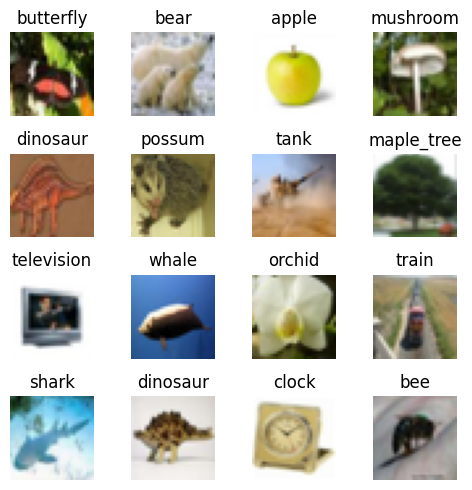

In [10]:
plt.figure(figsize=(5, 5))
for i in range (16):
  rand_num = np.random.randint(0, 50000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(train_images[rand_num])
  plt.title(labels_fine[train_labels[rand_num]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [37]:
seq = iaa.Sequential([
    # flip horizontal, siempre
    iaa.Fliplr(1.0),

    # random rotation between -25 and 25 degrees, always
    iaa.Affine(rotate=(-25, 25)),

    # Entre 2 y 5 de los siguientes efectos
    iaa.SomeOf((2, 5),
        [
            # Traslación en X, entre -5px y 5px
            iaa.Affine(translate_px={"x": (-5, 5)}),

            # Traslación en Y, entre -5px y 5px
            iaa.Affine(translate_px={"y": (-5, 5)}),

            # sesgo (shear) a la imagen en un rango de -2 a 2 grados,
            # con modos de borde 'symmetric' y 'wrap'
            iaa.Affine(shear=(-2, 2), mode=['symmetric', 'wrap']),

            # escala en x e y, entre .0 y 1.1
            iaa.Affine(scale={"x": (0.90, 1.10), "y": (0.90, 1.10)}),

            # recorta y rellena la imagen entre -2px y 2px
            # sin importarr el borde, con modos de relleno 'constant' y 'edge'
            iaa.CropAndPad(px=(-2, 2),
                           sample_independently=True,
                           pad_mode=["constant", "edge"]),

            # suma entre -0.15 y 0.15 a cada px
            # aplicándolo por canal con una prob de .5
            iaa.Add((-0.15, 0.15), per_channel=0.5),

            # multiplica cada px por entre .95 y 1.15,
            # aplicándolo por canal con una prob de 0.5
            iaa.Multiply((0.95, 1.15), per_channel=0.5),

            # factor de contraste, entre .8 y 1.4
            iaa.LinearContrast((0.8, 1.4)),

            # rellena con rectángulos con valores gaussianos,
            # con entre 1 y 4 iteraciones y un tamaño de 0.10 (respecto al 32x32)
            iaa.Cutout(fill_mode="gaussian", nb_iterations=(1, 4), size=0.10),
        ], random_order=True) # aplica lo anterior en orden random
], random_order=True) # aplica lo anterior en orden random


In [38]:
aug_test = seq.augment_images(images=train_images[:1000])

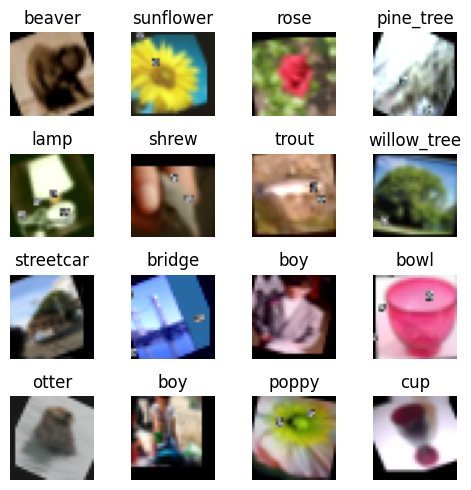

In [39]:
plt.figure(figsize=(5, 5))
for i in range (16):
  rand_num = np.random.randint(0, 1000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(aug_test[rand_num])
  plt.title(labels_fine[train_labels[rand_num]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# train_images_aug1 = seq.augment_images(train_images)
# train_images_aug2 = seq.augment_images(train_images)
# train_images_aug3 = seq.augment_images(train_images)
# train_images_aug4 = seq.augment_images(train_images)

In [ ]:
# train_images_aug_all = []
# train_images_aug_all.extend(train_images)
# train_images_aug_all.extend(train_images_aug1)
# train_images_aug_all.extend(train_images_aug2)
# train_images_aug_all.extend(train_images_aug3)
# train_images_aug_all.extend(train_images_aug4)

In [ ]:
# train_labels_aug_all = []
# train_labels_aug_all.extend(train_labels)
# train_labels_aug_all.extend(train_labels)
# train_labels_aug_all.extend(train_labels)
# train_labels_aug_all.extend(train_labels)
# train_labels_aug_all.extend(train_labels)

In [ ]:
# print(len(train_images_aug_all))
# print(len(train_labels_aug_all))

In [ ]:
# train_images_final = train_images
# train_labels_final = train_labels

In [ ]:
# train_images_final = train_images_aug_all
# train_labels_final = train_labels_aug_all

# combined = list(zip(train_images_aug_all, train_labels_aug_all))
# random.shuffle(combined)

# train_images_final[:], train_labels_final[:] = zip(*combined)

In [ ]:
# train_images_final = np.asarray(train_images_final)
# train_labels_final = np.asarray(train_labels_final)

In [34]:
# with open('train_images_final.pkl', 'wb') as f:
#     pickle.dump(train_images_final, f)

# with open('train_labels_final.pkl', 'wb') as f:
#     pickle.dump(train_labels_final, f)
    
    
train_images_final = []
train_labels_final = []   

with open('train_images_final.pkl', 'rb') as f:
    train_images_final = pickle.load(f)

with open('train_labels_final.pkl', 'rb') as f:
    train_labels_final = pickle.load(f)

In [35]:
print(train_images_final.shape)
print(train_labels_final.shape)

(250000, 32, 32, 3)
(250000,)


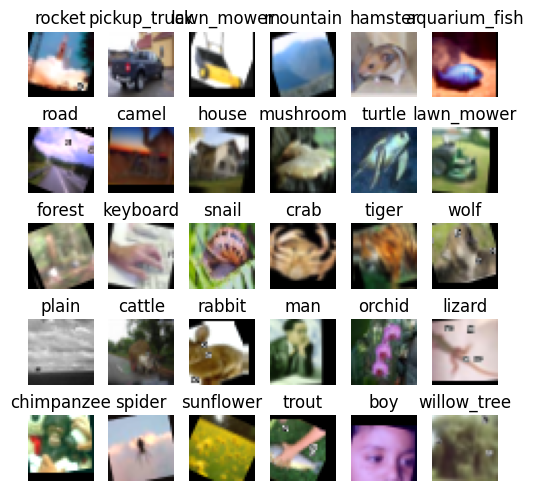

In [36]:
plt.figure(figsize=(5, 5))
for i in range(30):
    rand_num = np.random.randint(0, 250000)
    cifar_img = plt.subplot(5, 6, i + 1)
    plt.imshow(train_images_final[rand_num])
 
    plt.title(labels_fine[train_labels_final[rand_num]]) 
    plt.axis('off')

plt.tight_layout()
plt.show()

## CNNModel

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Conv2D, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import collections

from tensorflow.keras import Model, mixed_precision
import tensorflow as tf

In [10]:
base_model = Sequential()

base_model.add(Conv2D(128, (3, 3), padding='same', activation='swish', input_shape=(32, 32, 3)))
base_model.add(BatchNormalization())
base_model.add(Conv2D(128, (3, 3), padding='same', activation='swish'))
base_model.add(BatchNormalization())

base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Dropout(0.2))


base_model.add(Conv2D(256, (3, 3), padding='same', activation='swish'))
base_model.add(BatchNormalization())
base_model.add(Conv2D(256, (3, 3), padding='same', activation='swish'))
base_model.add(BatchNormalization())

base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Dropout(0.3))


base_model.add(Conv2D(512, (3, 3), padding='same', activation='swish'))
base_model.add(BatchNormalization())
base_model.add(Conv2D(512, (3, 3), padding='same', activation='swish'))
base_model.add(BatchNormalization())

base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Dropout(0.4))


base_model.add(Flatten())
base_model.add(Dense(1024, activation='swish'))
base_model.add(Dropout(0.5))
base_model.add(Dense(512, activation='swish'))
base_model.add(Dropout(0.5))
base_model.add(Dense(100, activation='softmax'))

base_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,80

 Total params: 13,549,284 (51.69 MB)

 Trainable params: 13,545,700 (51.67 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [13]:
num_epochs = 200
batch_size = 512
base_lr = 0.001

In [14]:
base_optimizer = Adam(learning_rate=base_lr)

In [11]:
# model = CustomModel(base_model)
model = base_model

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=base_optimizer,
              metrics=['accuracy'])

In [19]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 5,
    verbose = 1,
    min_lr = 1e-5,
    min_delta=0.001,
)

In [20]:
mc = ModelCheckpoint(
#     ".weights.h5",
    filepath='/kaggle/working/best_model.keras',
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True
#     save_weights_only = True,
)

In [21]:
es = EarlyStopping(
    monitor = "val_accuracy",
    min_delta=0.001,
    patience = 12, 
    verbose = 1,
    restore_best_weights = True,
)

In [33]:
train_labels_final_tweak = to_categorical(train_labels_final)
print(train_labels_final_tweak.shape)
print(train_images_final.shape)

(250000, 100)
(250000, 32, 32, 3)


In [34]:
history = model.fit(x=train_images_final,
                    y=train_labels_final_tweak,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_split=0.2,
                    callbacks=[rlrop, es, mc])

Epoch 1/200


I0000 00:00:1718857904.446709     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718857904.474638     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718857904.475282     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.0425 - loss: 4.6092

W0000 00:00:1718858065.938840     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718858065.939337     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.0425 - loss: 4.6082

W0000 00:00:1718858068.638233     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718858093.533037     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.02186, saving model to /kaggle/working/best_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 262s 486ms/step - accuracy: 0.0426 - loss: 4.6072 - val_accuracy: 0.0219 - val_loss: 4.6657 - learning_rate: 0.0010
Epoch 2/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.1357 - loss: 3.6397
Epoch 2: val_accuracy improved from 0.02186 to 0.21048, saving model to /kaggle/working/best_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 128s 329ms/step - accuracy: 0.1358 - loss: 3.6392 - val_accuracy: 0.2105 - val_loss: 3.3022 - learning_rate: 0.0010
Epoch 3/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.2434 - loss: 3.0356
Epoch 3: val_accuracy did not improve from 0.21048
391/391 ━━━━━━━━━━━━━━━━━━━━ 141s 327ms/step - accuracy: 0.2434 - loss: 3.0354 - val_accuracy: 0.1852 - val_loss: 3.5820 - learning_rate: 0.0010
Epoch 4/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.3499 - loss: 2.5094
Epoch 4: val_accuracy improved from 0.2

In [18]:
model.load_weights('/kaggle/working/best_model.keras')

In [60]:
history_dict = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

Perdí `history` por que se frenó el kernel.

Quedó el output del fit, así que, con ayuda de don GPT, a partir del log, armé un history_dict.pkl con acc, `val_acc`, `loss`, y `val_loss`, solo a fines de plotear acc y loss.

In [63]:
with open("/kaggle/input/history-dict-pkl/history_dict.pkl", "rb") as f:
    history_dict = pickle.load(f)

In [ ]:
# history_dict = history.history

In [64]:
print(history_dict.keys())

dict_keys(['accuracy', 'val_accuracy', 'loss', 'val_loss'])


In [65]:
print('Train loss:', history_dict['loss'][-1])
print('Train acc:', history_dict['accuracy'][-1])
print('Validation loss:', history_dict['val_loss'][-1])
print('Validation acc:', history_dict['val_accuracy'][-1])

Train loss: 0.1687
Train acc: 0.9463
Validation loss: 0.7888
Validation acc: 0.8052


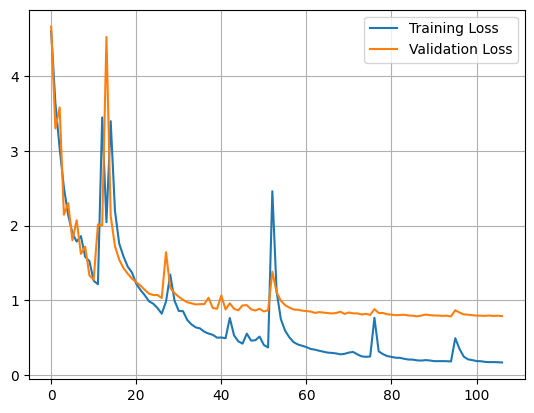

In [66]:
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.grid()
plt.legend()

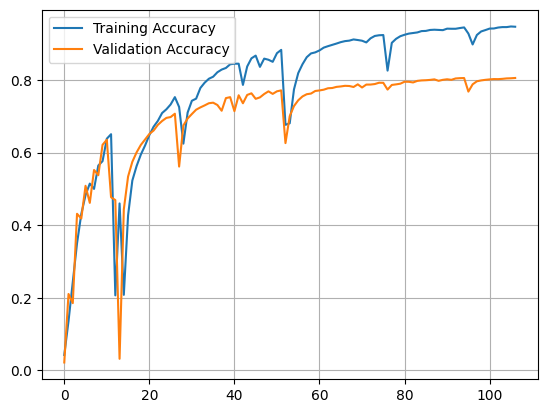

In [68]:
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.grid()
plt.legend()

In [69]:
test_images_aux = test_images

In [70]:
predictions = model.predict(test_images_aux).argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 361ms/step


In [71]:
print(predictions.shape)
print(predictions[1])

(10000,)
33


Some predictions:


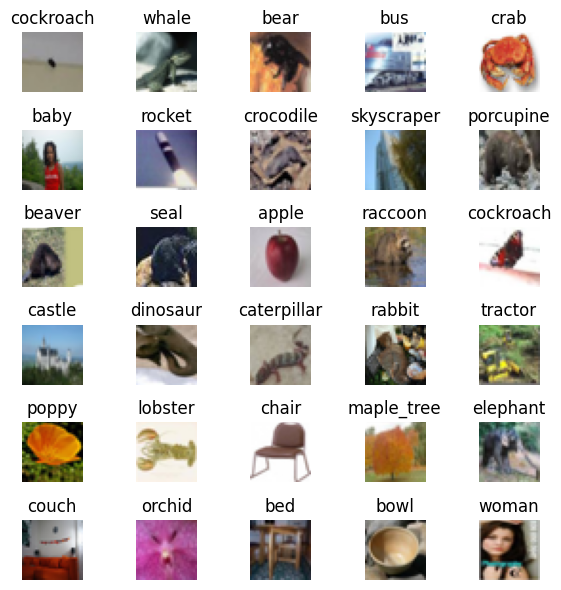

In [72]:
print("Some predictions:")

plt.figure(figsize=(6, 6))
for i in range (30):
  rand_num = np.random.randint(0, 10000)
  cifar_img = plt.subplot(6,5, i+1)
  plt.imshow(test_images_aux[rand_num])
  plt.title(labels_fine[predictions[rand_num]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [73]:
df = pd.DataFrame(predictions, columns=["Label"])
df.index.name = "Id"
df.head()
df.to_csv("submission.csv")

In [27]:
%cd /kaggle/working

/kaggle/working


<a href="submission.csv"> Download submission.csv </a>

<a href="best_model.keras"> Download best_model.keras </a>

<a href="train_images_final.pkl"> Download train_images_final.pkl </a>

<a href="train_labels_final.pkl"> Download train_labels_final.pkl </a>